<a href="https://colab.research.google.com/github/ncbx666/UniversityRep/blob/main/lab09_gan_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

100%|██████████| 22.0M/22.0M [00:00<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [60]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [61]:
data = datasets.MNIST(root='path', train=True, transform=transform, download=True)

In [62]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: path
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [63]:
data_loader = DataLoader(data, batch_size=64, shuffle=True)
for images, labels in data_loader:
    print(images.shape)  # (64, 1, 28, 28)
    print(labels.shape)  # (64)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [114]:
mnist_dim = 784
num_classes = 10

In [115]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Пропускное соединение
        out = self.relu(out)
        return out

In [117]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10):
        super(Generator, self).__init__()
        ngf = 128  # Количество фильтров базового уровня

        # Обработка шума
        self.noise = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )

        # Обработка меток через ConvTranspose2d
        self.label = nn.Sequential(
            nn.ConvTranspose2d(num_classes, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            ResidualBlock(ngf * 8),  # Добавляем residual block
            ResidualBlock(ngf * 8),  # Можно добавить несколько блоков
        )

        # Сверточные слои для объединённого входа
        self.main = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 2, 2, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, label):
        # Обработка шума и меток
        label = label.view(label.size(0), -1, 1, 1)  # Преобразование меток в размер [batch_size, num_classes, 1, 1]
        label = self.label(label)

        noise = noise.view(noise.size(0), -1, 1, 1)  # Преобразование шума в размер [batch_size, noise_dim, 1, 1]
        noise = self.noise(noise)

        # Объединение шума и меток по канальному измерению
        x = torch.cat([noise, label], dim=1)

        # Применение residual blocks
        x = self.residual_blocks(x)

        # Генерация изображения
        x = self.main(x)

        # Преобразуем выход в вектор длины 784
        x = x.view(x.size(0), -1)  # [batch_size, 784]
        return x

In [118]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Сверточные слои для обработки изображений
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [1, 28, 28] -> [32, 14, 14]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [32, 14, 14] -> [64, 7, 7]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # [64, 7, 7] -> [128, 4, 4]
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Линейные слои для обработки изображений и меток
        self.image_fc = nn.Linear(128 * 4 * 4, 1024)  # Для преобразования сверточных признаков
        self.label_fc = nn.Linear(10, 1024)  # Для обработки меток

        # Полносвязные слои с нормализацией и дропаутом
        self.main = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Выходное значение в диапазоне [0, 1]
        )

    def forward(self, input, label):
        # Преобразуем входное изображение в размерность [batch_size, 1, 28, 28]
        input = input.view(input.size(0), 1, 28, 28)

        # Пропускаем изображение через сверточные слои
        x = self.conv_layers(input)
        x = x.view(x.size(0), -1)  # Разворачиваем в вектор [batch_size, 128*4*4]

        # Пропускаем сверточные признаки и метки через линейные слои
        x = F.leaky_relu(self.image_fc(x), 0.2)
        y = F.leaky_relu(self.label_fc(label), 0.2)

        # Конкатенируем обработанные изображения и метки
        x = torch.cat([x, y], dim=1)

        # Пропускаем через основные линейные слои
        x = self.main(x)

        return x

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [120]:
# Создаем экземпляры генератора и дискриминатора
G = Generator().to(device)
D = Discriminator().to(device)

In [121]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (image_fc): Linear(in_features=2048, out_features=1024, bias=True)
  (label_fc): Linear(in_features=10, out_features=1024, bias=True)
  (main): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Leak

Epoch [1/20], D Loss: 0.9193, G Loss: 1.3307


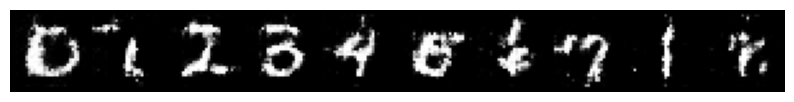

Epoch [2/20], D Loss: 1.1025, G Loss: 1.3736


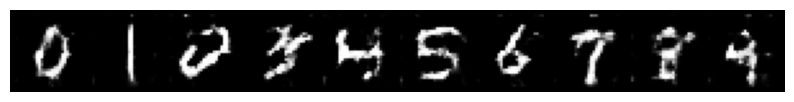

Epoch [3/20], D Loss: 1.3093, G Loss: 1.0603


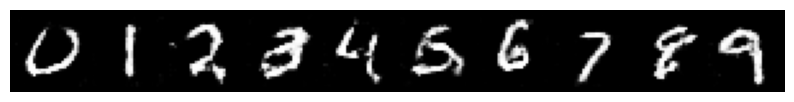

Epoch [4/20], D Loss: 1.2658, G Loss: 1.0801


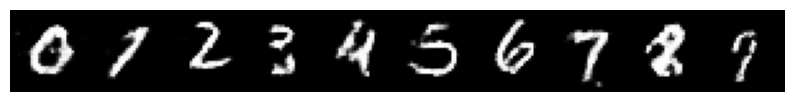

Epoch [5/20], D Loss: 1.2574, G Loss: 1.0779


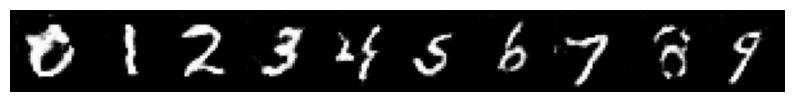

Epoch [6/20], D Loss: 1.2588, G Loss: 1.0617


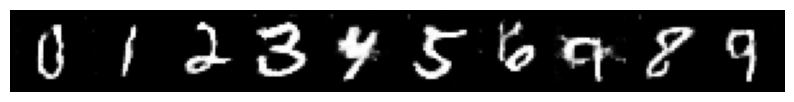

Epoch [7/20], D Loss: 1.2476, G Loss: 1.0696


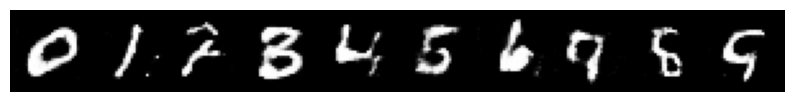

Epoch [8/20], D Loss: 1.2134, G Loss: 1.1303


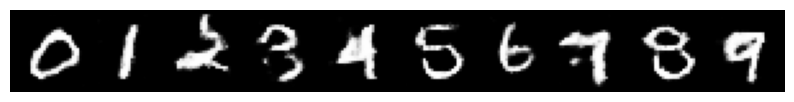

Epoch [9/20], D Loss: 1.1992, G Loss: 1.1585


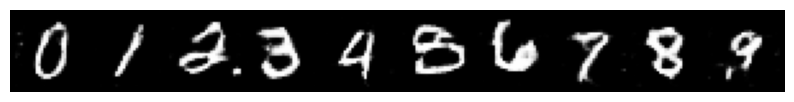

Epoch [10/20], D Loss: 1.1875, G Loss: 1.2011


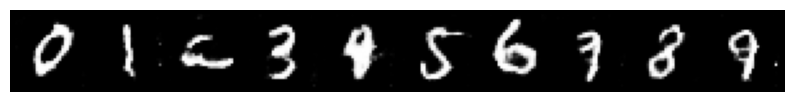

Epoch [11/20], D Loss: 1.1725, G Loss: 1.2416


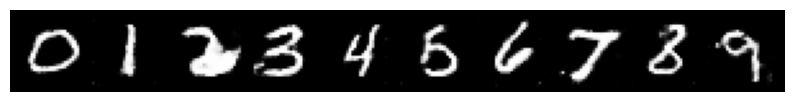

Epoch [12/20], D Loss: 1.1499, G Loss: 1.2861


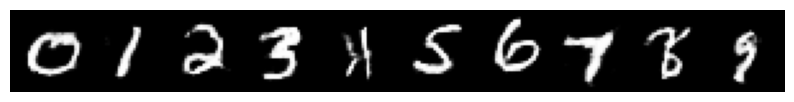

Epoch [13/20], D Loss: 1.1407, G Loss: 1.3280


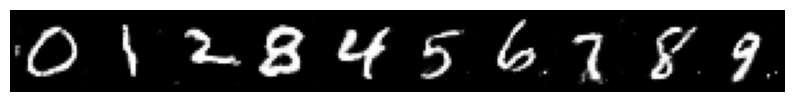

Epoch [14/20], D Loss: 1.1427, G Loss: 1.3523


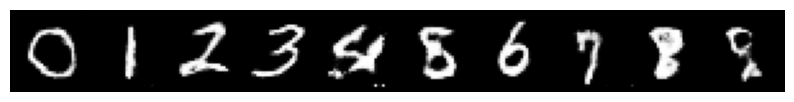

Epoch [15/20], D Loss: 1.0975, G Loss: 1.4097


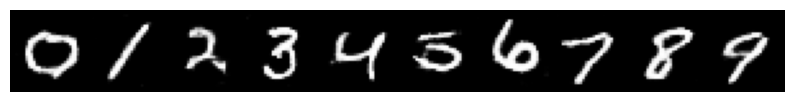

Epoch [16/20], D Loss: 1.0525, G Loss: 1.5326


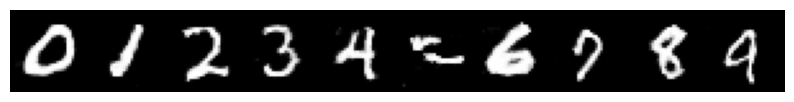

Epoch [17/20], D Loss: 1.0283, G Loss: 1.6061


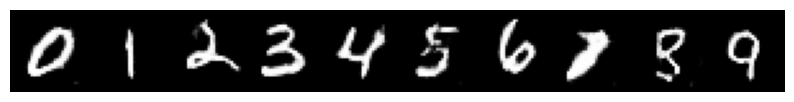

Epoch [18/20], D Loss: 1.0355, G Loss: 1.6373


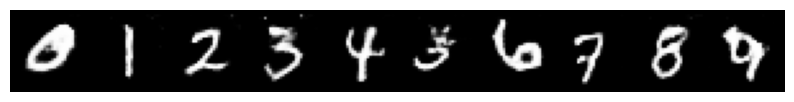

Epoch [19/20], D Loss: 1.0582, G Loss: 1.6007


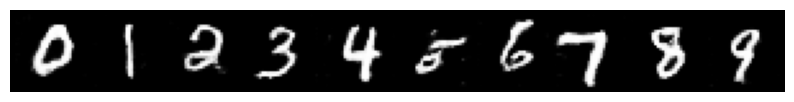

Epoch [20/20], D Loss: 1.0176, G Loss: 1.6873


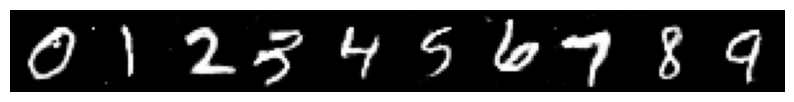

In [122]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

criterion = nn.BCELoss()  # Используем бинарную кросс-энтропию
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-7)
G_optimizer = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-4)

batch_size = 64
NUM_EPOCH = 20

for epoch in range(NUM_EPOCH):  # Количество эпох
    G.train()
    D.train()

    # Инициализация переменных для накопления лоссов
    D_epoch_loss = 0
    G_epoch_loss = 0

    for batch_idx, (real_images, labels) in enumerate(data_loader):
        mini_batch = real_images.size(0)

        # Преобразуем изображения в форму (batch_size, 1, 28, 28)
        real_images = real_images.to(device).float()
        labels = labels.to(device).long()  # Убедитесь, что метки имеют правильный тип данных

        y_real_ = torch.ones(mini_batch).to(device).float()  # Реальные метки для дискриминатора
        y_fake_ = torch.zeros(mini_batch).to(device).float()  # Фальшивые метки для дискриминатора
        y_label_ = torch.zeros(mini_batch, 10).to(device).float()  # Ожидаемые one-hot метки для категорий
        y_label_.scatter_(1, labels.view(mini_batch, 1), 1)

        # Обучение дискриминатора
        D.zero_grad()

        D_result = D(real_images, y_label_).view(-1)  # Преобразуем выход в плоский вектор
        D_real_loss = criterion(D_result, y_real_)

        # Генерация фальшивых изображений
        z_ = torch.randn(mini_batch, 100).to(device).float()  # Генерация шума для генератора
        fake_images = G(z_, y_label_)

        # Дискриминатор обрабатывает фейковые изображения
        D_result = D(fake_images.detach(), y_label_).view(-1)  # Преобразуем выход в плоский вектор
        D_fake_loss = criterion(D_result, y_fake_)

        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()

        # Обучение генератора
        G.zero_grad()

        # Обновление генератора
        fake_images = G(z_, y_label_)
        D_result = D(fake_images, y_label_).squeeze()

        G_train_loss = criterion(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        # Накопление лоссов для статистики по эпохе
        D_epoch_loss += D_train_loss.item()
        G_epoch_loss += G_train_loss.item()

    # Выводим лоссы после завершения эпохи
    print(f"Epoch [{epoch+1}/{NUM_EPOCH}], D Loss: {D_epoch_loss/len(data_loader):.4f}, G Loss: {G_epoch_loss/len(data_loader):.4f}")

    # Выводим изображения после каждой эпохи
    G.eval()  # Включаем режим оценки для генератора
    with torch.no_grad():
        z = torch.randn(10, 100).to(device)  # 10 изображений, размер вектора 100
        labels = torch.arange(0, 10).to(device)  # Метки от 0 до 9
        labels_one_hot = torch.zeros(10, 10).to(device)
        labels_one_hot.scatter_(1, labels.view(-1, 1), 1)

        # Генерация изображений
        fake_images = G(z, labels_one_hot)
        fake_images = fake_images.view(-1, 1, 28, 28)  # Преобразуем для визуализации

        # Визуализируем изображения
        grid = vutils.make_grid(fake_images, nrow=10, normalize=True, scale_each=True)
        plt.figure(figsize=(10, 2))  # Горизонтальная сетка
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.show()


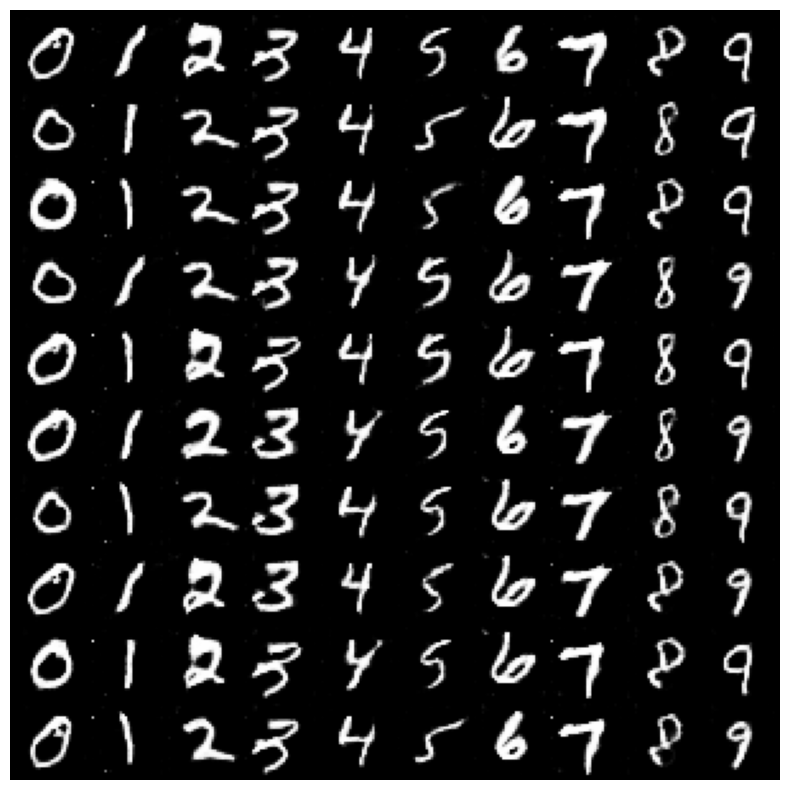

In [123]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Убедитесь, что генератор G и устройство (device) правильно заданы
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.to(device)

# Генерация случайного шума для входа в генератор
z = torch.randn(100, 100).to(device)  # 100 изображений, размер входного вектора 100
labels = torch.arange(0, 10).to(device).repeat(10)  # Метки от 0 до 9, повторяются 10 раз для каждой

# Генерация изображений для каждого класса
with torch.no_grad():  # Мы не обучаем модель, поэтому отключаем вычисление градиентов
    # Преобразуем метки в one-hot формат
    labels_one_hot = torch.zeros(100, 10).to(device)
    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)

    # Подаем в генератор оба аргумента: вектор шума и one-hot метки
    fake_images = G(z, labels_one_hot)  # Подаем в генератор

# Преобразуем изображения в правильный формат для отображения (предполагаем размер 28x28)
fake_images = fake_images.view(-1, 1, 28, 28)

# Визуализируем изображения
grid = vutils.make_grid(fake_images, nrow=10, normalize=True, scale_each=True)
plt.figure(figsize=(10, 10))  # Форматируем фигуру для вывода изображений в сетку 10x10
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Перемещаем каналы в правильный порядок
plt.axis('off')  # Убираем оси
plt.show()


lr=0.00002
lr=0.0005
num_epoch=30

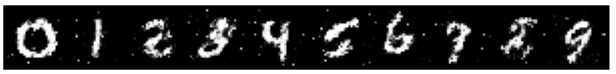